In [27]:
import os
import pandas as pd
import json
import folium 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

import chardet
import topojson
import geopandas as gpd

**Question 1: ** Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.


### a. Work on the dataset

From the eurostat website, we download an excel file containing the informations on unemployment rate in Europe, per Country, from 1990 to 2016. 

We load this dataset into a pandas DataFrame, that we first need to clean, to keep only columns and rows with relevant informations. 

In [28]:
# Load excel file into pandas DataFrame with no header
UNEMPLOYMENT_RATE_EUROSTAT_PATH = r'data/unemployment_rate_eurostat.xls'
df_excel_eurostat = pd.read_excel(UNEMPLOYMENT_RATE_EUROSTAT_PATH, 
                                  skiprows = 4, 
                                  skip_footer = 9, 
                                  sheetname = 'Sheet0', 
                                  header = None)

# Work on header 
header = pd.read_excel(UNEMPLOYMENT_RATE_EUROSTAT_PATH, sheetname = 'Sheet0', header = 3).columns
header.values[0] = 'Country'
df_excel_eurostat.columns = header


# Drop columns full of NaN 
df_eurostat = df_excel_eurostat.dropna(axis = 1)

# Remove first columns which are balance for Europe
df_eurostat = df_eurostat[4:] 

df_eurostat.head()

,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
4,Belgium,6.6,6.4,7.1,8.6,9.8,9.7,9.5,9.2,9.3,...,7.5,7,7.9,8.3,7.2,7.6,8.4,8.5,8.5,7.8
5,Bulgaria,:,:,:,:,:,:,:,:,:,...,6.9,5.6,6.8,10.3,11.3,12.3,13,11.4,9.2,7.6
6,Czech Republic,:,:,:,4.3,4.3,4,3.9,4.8,6.5,...,5.3,4.4,6.7,7.3,6.7,7,7,6.1,5.1,4
7,Denmark,7.2,7.9,8.6,9.6,7.7,6.7,6.3,5.2,4.9,...,3.8,3.4,6,7.5,7.6,7.5,7,6.6,6.2,6.2
8,Germany,:,5.5,6.6,7.8,8.4,8.2,8.9,9.6,9.4,...,8.5,7.4,7.6,7,5.8,5.4,5.2,5,4.6,4.1


In [29]:
# Treat missing values
df_eurostat = df_eurostat.replace(':','nan')
# df_eurostat = df_eurostat.replace('(p)','NaN')
df_eurostat.head()

,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
4,Belgium,6.6,6.4,7.1,8.6,9.8,9.7,9.5,9.2,9.3,...,7.5,7,7.9,8.3,7.2,7.6,8.4,8.5,8.5,7.8
5,Bulgaria,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,6.9,5.6,6.8,10.3,11.3,12.3,13,11.4,9.2,7.6
6,Czech Republic,nan,nan,nan,4.3,4.3,4,3.9,4.8,6.5,...,5.3,4.4,6.7,7.3,6.7,7,7,6.1,5.1,4
7,Denmark,7.2,7.9,8.6,9.6,7.7,6.7,6.3,5.2,4.9,...,3.8,3.4,6,7.5,7.6,7.5,7,6.6,6.2,6.2
8,Germany,nan,5.5,6.6,7.8,8.4,8.2,8.9,9.6,9.4,...,8.5,7.4,7.6,7,5.8,5.4,5.2,5,4.6,4.1


We will work only with the data from 2016. Hence, we keep only the columns Country and 2016. As an anticipation for later reuse, we convert the rate values as float. Until now, they were string.

In [30]:
df_EU_2016 = df_eurostat[['Country','2016']]
df_EU_2016['2016'] = df_EU_2016['2016'].astype(float)

/Users/Hippo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We notice that all values seem correct, except for Switzerland, which always has undefined rates over the years. As a consequence, we remove Switzerland from the dataset. We will study its case in the next part of this work.

In [31]:
# Remove Switzerland (NaN value)
ind_Switzerland = df_EU_2016.index[ df_EU_2016.Country == 'Switzerland' ].tolist()
df_EU_2016 = df_EU_2016.drop(ind_Switzerland, axis = 0)

Let's check the other countries of our dataset.

In [32]:
print("There are {} countries in our dataset.\n".format(df_EU_2016.Country.count()))
print(df_EU_2016.Country.tolist())

There are 33 countries in our dataset.

['Belgium', 'Bulgaria', 'Czech Republic', 'Denmark', 'Germany', 'Estonia', 'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy', 'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta', 'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'United Kingdom', 'Iceland', 'Norway', 'Turkey', 'United States', 'Japan']


We see that some countries from the data need to be deleted for our European analysis. We identify Japan and the United States that we should get rid of, as they are not in Europe. However, we do not limit our study to the European Union, thus we keep Iceland, Norway and Estonia.

In [33]:
ind_US = df_EU_2016.index[ df_EU_2016.Country == 'United States' ].tolist()
df_EU_2016 = df_EU_2016.drop(ind_US, axis = 0)

ind_Japan = df_EU_2016.index[ df_EU_2016.Country == 'Japan' ].tolist()
df_EU_2016 = df_EU_2016.drop(ind_Japan, axis = 0)

print("Final {} countries in our dataset:\n\n{}".format(df_EU_2016.Country.count(), df_EU_2016.Country.tolist()))

Final 31 countries in our dataset:

['Belgium', 'Bulgaria', 'Czech Republic', 'Denmark', 'Germany', 'Estonia', 'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy', 'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta', 'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'United Kingdom', 'Iceland', 'Norway', 'Turkey']


### b. Work on the map

Now that our data are ready, we would like to display them on a map. To do so, we have a TopoJSON file which defines the boundaries of the countries in Europe. 





In [34]:
# Path to our topoJSON
TOPOJSON_EUROPE_PATH = r'topojson/europe.topojson.json'

# Load TopoJSON
topojson_europe = json.load(open(TOPOJSON_EUROPE_PATH))

#### Compare countries in dataset and TopoJSON

We get the countries from the TopoJSON in a new list, in order to compare it ti the one we have in our dataset.  

In [35]:
with open(TOPOJSON_EUROPE_PATH) as file:    
    topojson = json.load(file)
    topo_countries = sorted([country['properties']['NAME'] for country in topojson['objects']['europe']['geometries']])

print("Number of countries in TopoJSON: %d" % len(topo_countries))

Number of countries in TopoJSON: 51


First, we notice that we have 51 countries in this TopoJSON. Thus, some countries might be present in our TopoJSON file while they are not in our dataset. As we do not have values for their unemployment rate, we won't display them on the map. 

In [36]:
df_countries = sorted(df_EU_2016.Country)
print("Countries in dataframe: \n{}".format(sorted(df_EU_2016.Country)))
print("\n\nCountries in TopoJSON: \n{}".format(sorted(topo_countries)))

Countries in dataframe: 
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Turkey', 'United Kingdom']


Countries in TopoJSON: 
['Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Faroe Islands', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Holy See (Vatican City)', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Monaco', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Republic of Moldova', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'The 

Now we need to compare countries from our eurostat dataset and the ones from the topojson. We checked that no country is present in the dataset and is not in the topojson.  

We are going to delete the 'extra' countries on the map.

In [37]:
# Missing country
missing_countries = list()
for country_from_topo in topo_countries:
    found = False
    for country_from_df in df_countries:
        if country_from_df == country_from_topo:
            found = True
    if found == False:
        missing_countries.append(country_from_topo)
        
print("Countries we are about to delete from our topojson: \n")
print(missing_countries)
        

Countries we are about to delete from our topojson: 

['Albania', 'Andorra', 'Armenia', 'Azerbaijan', 'Belarus', 'Bosnia and Herzegovina', 'Faroe Islands', 'Georgia', 'Holy See (Vatican City)', 'Israel', 'Liechtenstein', 'Monaco', 'Montenegro', 'Republic of Moldova', 'Russia', 'San Marino', 'Serbia', 'Switzerland', 'The former Yugoslav Republic of Macedonia', 'Ukraine']


Let's get rid of them!

In [38]:
final_json_europe = topojson_europe 
for m_country in missing_countries:
    for ind, country_topo in  enumerate(final_json_europe['objects']['europe']['geometries']):
        if country_topo['properties']['NAME'] == m_country:
            del final_json_europe['objects']['europe']['geometries'][ind]

#### Display on the map

We create a map using `folium`, centered on Berlin. On top of this map, we overlay the informations found in a TopoJSON file. Those information are the boundaries of each country.

In [39]:
# Build map center on Berlin with zoom that we can see all the Europe 
berlin_coord = [52.520008, 13.404954]

m_europe = folium.Map(location = berlin_coord, zoom_start = 3.4)

folium.TopoJson(
    final_json_europe,
    'objects.europe',
    name='Country boundaries'
).add_to(m_europe)
m_europe.save("m_europe1.html")

**Visualize the map** : [Click here](https://hilefebvre.github.io/m_europe1.html)

#### On a map

On top of this map, we want to visualize the unemployment rate of each country, and we will do it using `choropleth`. This allows us to shade countries by group and according to their unemployment rate. 

We will have classes of countries, and all country in a same class have the same color. There are few way of determining those classes, and we are going to display the following data classification mode: Equal intervals and Natural breaks (Jenks) classification. We will determine which one is the most relevant. 


We choose sequential color from yellow (low unemployment rate) to red (high unemployment rate), so that we can see and compare contry to each others on the map. Moreover, this kind of pallette can be seen by colorblind people.



In a first display, we voluntary do not specify any threshold for the color, which means we don't determine classes. Hense, by default Folium will create 6 equal intervals in the range of our unemployment rates.

This results in an *Equal Interval Data Classification*. 


In [40]:
m_europe_eq_intervals = folium.Map(location = berlin_coord, zoom_start = 3.4)

m_europe_eq_intervals.choropleth(
    geo_data = final_json_europe,
    data = df_EU_2016,
    topojson = 'objects.europe',
    columns = ['Country', '2016'],
    key_on = 'feature.properties.NAME',
    fill_color='YlOrRd',
    legend_name='Unemployment Rate in Europe in 2016 (%) - Equal intervals'
)
m_europe_eq_intervals.save("m_europe_eq_intervals.html")

**Visualize the map** : [Click here](https://hilefebvre.github.io/m_europe_eq_intervals.html)

First of all, some countries are present in our TopoJSON, which means they are drawn on our map, but we don't have their corresponding rate values. This is the case of Switzerland that we previously removed. 

Here, we can see that through our dataset, the unemployment rate is between 3.0 and 24.0 (3.0 and 23.6 to be precise). Thus, the pallette goes between those two values. However, we have a majority of country with light colors. The choice of Equals intervals might not me the best one, as some classes might be a lot more populated than others.

Before choosing which data classification mode might be more appropriate in our case, we look at the repartition of the unemployment rate. 

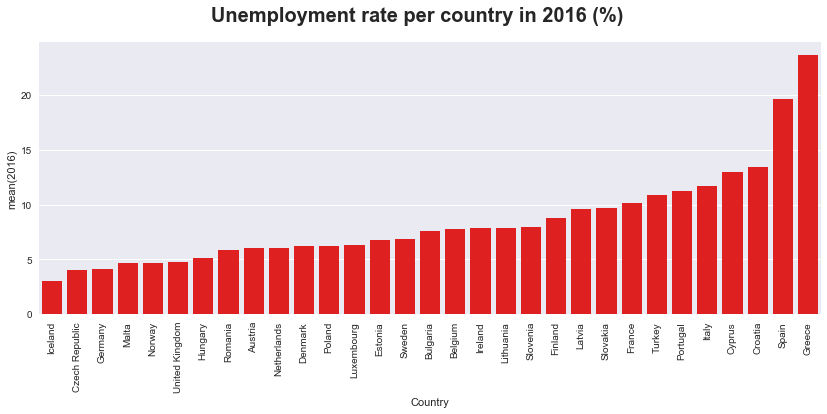

In [41]:
df_EU_2016 = df_EU_2016.sort_values('2016')

ax = plt.figure(figsize = (14,5))
g = sns.barplot(x = 'Country', y = "2016", data = df_EU_2016[['Country','2016']], color ='Red')
g.set_xticklabels(labels = df_EU_2016['Country'], rotation=90)
ax.suptitle("Unemployment rate per country in 2016 (%)", fontsize=20, fontweight="bold")

What we observe is that the repartition is quite regular, except for two countries, Spain and Greece, that we can consider as two outliers. 

According to this [webpage](http://gisgeography.com/choropleth-maps-data-classification/), we see that *Natural Breaks Classification* optimizes the variation within a class. What we have especially noticed, is that it takes into account the outliers, that would be classified in a same classe. The repartition among classes would be more heterogenous with this method


Let's try the natural breaks classification, then!

To do this, we use `pysal` (Python Spatial Analysis Library) to determine our natural breaks. We do it for `k = 6`, to keep the same number of classes as in the equal intervals method.

In [42]:
import pip
try: 
    import pysal 
except:
    install_pysal = pip.main(['install', 'pysal'])
    import pysal

In [43]:
data = df_EU_2016['2016']
df_2016_array = np.ndarray([len(data), 1])

# Natural breaks input must be an array (n, 1)
for i in range(len(data)):
    df_2016_array[i,0] = data.values[i]

# Compute the natural breaks
nb = pysal.Natural_Breaks(df_2016_array, k = 5)

# pysal.Natural_Breaks returns only the upper bound. We need to add the first lower one
nb_list = nb.bins.tolist()
nb_list.insert(0, np.min(data))

m_europe_nb = folium.Map(location = berlin_coord, zoom_start = 3.4)
m_europe_nb.choropleth(
    geo_data = final_json_europe,
    data = df_EU_2016,
    topojson = 'objects.europe',
    columns = ['Country', '2016'],
    key_on = 'feature.properties.NAME',
    fill_color='YlOrRd',
    threshold_scale = nb_list,
    legend_name='Unemployment Rate in Europe (%) - Natural breaks intervals'
)

m_europe_nb.save("m_europe_nb.html")

**Visualize the map** : [Click here](https://hilefebvre.github.io/m_europe_nb.html)

We notice on the above map that southern countries in Europe tend to have higher unemployment rates. 

Moreover, the natural breaks method shows a map with more constrast between the countries. For example, France was shown in a light color in the first map, which seemed to tell that its unemployment rate is not that high. However, when we take a look at the barplot *Unemployment rate per country in 2016*, we notice that in fact, France is in the upper half of the countries by its unemployment rate. This is easier to understand with the second map using natural breaks.



------

**Question 2:** 
Go to the amstat website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

HINT Go to the details tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through.
Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

**PART 1: Data analysis of unemployement rates (only concerns registered unemployed people)**

**1- Loading data on unemployement rates by canton in Switzerland** <br>
The following loaded csv file was created through the amstat website https://www.amstat.ch/v2/index.jsp, Details section where we selected the 'Chômeurs et demandeurs d'emploi' folder and then 'Taux de chômage' folder. We are then asked to chose parameters before being given a data file with relative information on the selected parameters. 
Therefore, to produce this first csv file we chose the following parameters:
- Période sous revue sélectionner: 'Mois sous revue'
- Indicateurs taux de chômage: 'Taux de chômage'
- Indicateurs chômeurs: None
- Indicateurs demandeurs d'emploi: None
- Caractéristiques géographiques: 'Canton'
- Optionnel: Restreindre les données géographiques à un ou plusieurs cantons: None
- Autres attributs: None

With these parameters, we are given a data file with information on the unemployement rates by canton which represents the number of registered unemployed people divided by the active population numbers, multiplied by 100. <br><br>
To read the data correctly, we use the character encoding library **chardet**.

In [44]:
unemployement_rates_file = 'data/unemployement_rate_by_canton_switzerland.csv'

with open(unemployement_rates_file, 'rb') as f:
    result = chardet.detect(f.read()) 

unemployement_rates_data = pd.read_csv(unemployement_rates_file, encoding=result['encoding'])

In [45]:
unemployement_rates_data.head()

,Canton,Mois,Septembre 2017,Total
0,,Mesures,Taux de chômage,Taux de chômage
1,Zurich,NaN,3.3,3.3
2,Berne,NaN,2.4,2.4
3,Lucerne,NaN,1.7,1.7
4,Uri,NaN,0.6,0.6


In [46]:
unemployement_rates_data.dtypes

Canton            object
Mois              object
Septembre 2017    object
Total             object
dtype: object

**2- Unemployement rates data pre processing**
- We drop the columns 'Mois' and 'Total' which are not relevant for our analysis.
- We also drop the first line of the dataframe which contains the index names of some of the columns (we will rename the columns accordingly afterwards).
- After droping the first line, we need to reset the index.
- We rename the remaining columns according to what the numbers represent. In that case: the unemployement rates per canton.
- We finally have to convert the unemployement rates related column to numeric for our analysis

In [47]:
unemployement_rates_data.drop(['Mois', 'Total'], axis=1, inplace = True)

In [48]:
unemployement_rates_data.drop([0,unemployement_rates_data.index.size-1], axis=0, inplace = True)
unemployement_rates_data.reset_index(drop = True, inplace = True)

In [49]:
unemployement_rates_data = unemployement_rates_data.rename(columns={'Septembre 2017' : 'Unemployement rate'})

In [50]:
unemployement_rates_data.head()

,Canton,Unemployement rate
0,Zurich,3.3
1,Berne,2.4
2,Lucerne,1.7
3,Uri,0.6
4,Schwyz,1.7


In [51]:
unemployement_rates_data['Unemployement rate'] = pd.to_numeric(unemployement_rates_data['Unemployement rate'])

**3- Loading topojson info on swiss cantons' geography**
- First, we get the topojson file on swiss cantons' path.
- Then, we use the **geopandas** library to read the topojson file and display the information it contains.

In [52]:
canton_geo_path = 'topojson/ch-cantons.topojson.json'

In [53]:
canton_geo_df = gpd.read_file(canton_geo_path)
canton_geo_df.head()

,id,name,geometry
0,ZH,Zürich,"POLYGON ((8.807614761476149 47.22089128912891,..."
1,BE,Bern/Berne,"(POLYGON ((7.824565256525654 47.2658697869787,..."
2,LU,Luzern,"POLYGON ((8.048666066606661 46.78782398239824,..."
3,UR,Uri,"POLYGON ((8.934635463546355 46.91997319731973,..."
4,SZ,Schwyz,"POLYGON ((8.568997299729974 46.98982918291829,..."


**4- Mapping french swiss cantons names and their german equivalent**<br>
From the above printed dataframes we can observe that the cantons' names are not matching because the data from the amstat website retrieve most of the cantons' names in their French version while the topojson file has them mostly written in their German one. Nevertheless, we also see that the order of display of the cantons is the same in both dataframes, so we just have to rely on the index to match the names and display them in one and only language. Arbitrarily, we have chosen the German version. 

In [54]:
unemployement_rates_data.Canton = canton_geo_df.name

In [55]:
unemployement_rates_data.Canton.head()

0        Zürich
1    Bern/Berne
2        Luzern
3           Uri
4        Schwyz
Name: Canton, dtype: object

**5- Merging the unemployement rates data and the topojson information on swiss cantons' geography**<br>
We merge the dataframe containg information on the unemployement rates and the geopandas one on the cantons topojson information. To do so, we rely on the name i.e. Cantons' appellation of the dataframes.

In [56]:
merged = canton_geo_df.merge(unemployement_rates_data, left_on='name', right_on='Canton')

In [57]:
merged.head()

,id,name,geometry,Canton,Unemployement rate
0,ZH,Zürich,"POLYGON ((8.807614761476149 47.22089128912891,...",Zürich,3.3
1,BE,Bern/Berne,"(POLYGON ((7.824565256525654 47.2658697869787,...",Bern/Berne,2.4
2,LU,Luzern,"POLYGON ((8.048666066606661 46.78782398239824,...",Luzern,1.7
3,UR,Uri,"POLYGON ((8.934635463546355 46.91997319731973,...",Uri,0.6
4,SZ,Schwyz,"POLYGON ((8.568997299729974 46.98982918291829,...",Schwyz,1.7


**6- Creating a geopandas dataframe with Swiss cantons' names and their respective geometry**<br>
After having created this geopandas dataframe, we convert its content to the json type.

In [58]:
canton_geo_gdf = gpd.GeoDataFrame(merged.iloc[:, [1, 2]])

In [59]:
canton_geo_gdf.head()

,name,geometry
0,Zürich,"POLYGON ((8.807614761476149 47.22089128912891,..."
1,Bern/Berne,"(POLYGON ((7.824565256525654 47.2658697869787,..."
2,Luzern,"POLYGON ((8.048666066606661 46.78782398239824,..."
3,Uri,"POLYGON ((8.934635463546355 46.91997319731973,..."
4,Schwyz,"POLYGON ((8.568997299729974 46.98982918291829,..."


In [60]:
canton_geo_to_json = canton_geo_gdf.to_json()

**7- Creating pop up windows for interactive unemployement rates information on the map**<br>
Indeed, we want the map to be as interactive as possible and make the information retrieved from the amstat website easy to reach and visible. To do so, we will make use of pop up windows which will relate information on the canton's name and its related unemployement rate.<br>
- First, we create a list of texts which contains the name and unemployement rate strings for each canton.
- Secondly, we create the pop up objects delimited by the respective geometry of each canton.

In [61]:
text = []
for i in range(unemployement_rates_data.index.size):
    text.append(unemployement_rates_data.Canton[i] +  '<br>' + 
                'Unemployement rate: ' + str(unemployement_rates_data['Unemployement rate'].loc[i]) + '%')

In [62]:
from shapely.geometry import Polygon, mapping
list_geo=[]
gj=[]
for i in range(canton_geo_gdf.index.size):
     list_geo.append(mapping(canton_geo_gdf['geometry'].loc[i]))
     gj.append(folium.GeoJson(list_geo[i], style_function=lambda feature: {
        'opacity' : 0.7 , 'fillColor': '#FFFFFFFF', 'color' : 'blue'
        }))

**8- Creating choropleth map to display Swiss cantons' unemployement rates information**<br>
- We have chosen the coordinates of the middle of Switzerland to center our map. 
- Then, we initialize our map with these coordinates and make it a choropleth map with the topojson information converted to json in the previous steps after pre processing of the Cantons' names and we use the data on unemployement rates to be displayed accordingly. We use a Yellow (low unemployement rate) to Green (high unemployement rate) sequential color which is by default divided into 6 equal intervals in the range of our unemployement rates values by folium. 
- Finally, we add the above created information strings into the pop up windows before displaying the choropleth map. 

In [63]:
middle_of_switzerland_coord = [46.801111, 8.226667]

In [64]:
swiss_map_unemployement_rates = folium.Map(middle_of_switzerland_coord, tiles='cartodbpositron', zoom_start = 8)

In [65]:
swiss_map_unemployement_rates.choropleth(geo_data=canton_geo_to_json,
              data=unemployement_rates_data, columns=['Canton', 'Unemployement rate'],
                     key_on='feature.properties.name', fill_color='YlGn', fill_opacity=1, line_opacity=0.2,
             legend_name='Unemployment Rate (%)')

In [66]:
for i in range(canton_geo_df.index.size):
    gj[i].add_child(folium.Popup(text[i]))
    gj[i].add_to(swiss_map_unemployement_rates)

**10- We save the above map to an html adress. In that case: ...**

In [67]:
swiss_map_unemployement_rates.save('unemployement_rates_by_canton.html')

**Visualize map here** : [Click here](https://hilefebvre.github.io/unemployement_rates_by_canton.html)

**11- Histogram of unemployements rates by canton**<br>
Before ending our analysis on unemployement rates by canton we also display an histogram to have another view of these rates according to the different cantons. To do so, we sort the values of unemployement rates in ascending order and display them afterwards.

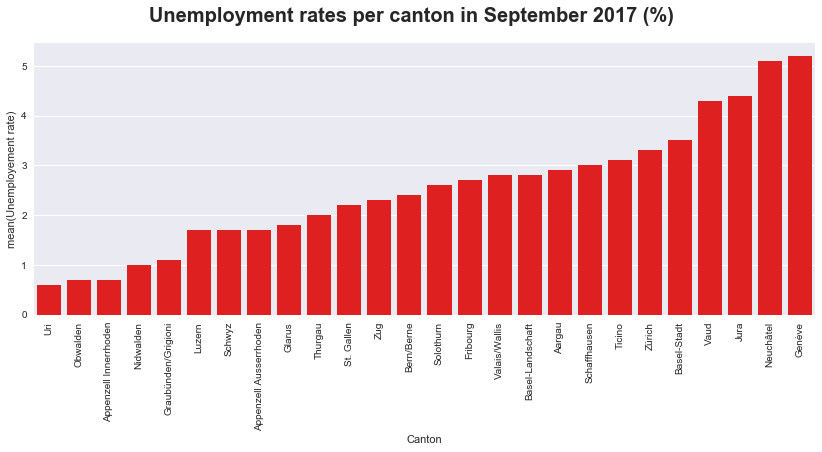

In [68]:
unemployement_rates_data_sorted = unemployement_rates_data.sort_values('Unemployement rate')
ax = plt.figure(figsize = (14,5))
g = sns.barplot(x = 'Canton', y = 'Unemployement rate', data = unemployement_rates_data_sorted[['Canton','Unemployement rate']], color ='Red')
g.set_xticklabels(labels = unemployement_rates_data_sorted['Canton'], rotation=90)
ax.suptitle("Unemployment rates per canton in September 2017 (%)", fontsize=20, fontweight="bold")

With this first analysis, it is not trivial to draw a lot of trends in the repartition of unemployement in Switzerland. Nevertheless, we see that the rates are higher in the cantons bordering France and Germany, maybe because French and German people use their geographic position to work in Switzerland, make a lot of money and still Swiss people jobs. However, in the middle and in the east of Siwtzerland the rates are quiet low.

**PART 2: Data analysis of jobseekers rates and employed jobseekers rates**


**1- Loading data on jobseekers and employed jobseekers numbers by canton in Switzerland** <br>
The following loaded csv file was created through the amstat website https://www.amstat.ch/v2/index.jsp, Details section where we selected the 'Chômeurs et demandeurs d'emploi' folder and then 'Taux de chômage' folder. We are then asked to chose parameters before being given a data file with relative information on the selected parameters. 
Therefore, to produce this second csv file we chose the following parameters:
- Période sous revue sélectionner: 'Mois sous revue'
- Indicateurs taux de chômage: 'Taux de chômage'
- Indicateurs chômeurs: 'Chômeurs inscrits'
- Indicateurs demandeurs d'emploi: 'Demandeurs d'emploi', 'Demandeurs d'emploi non chômeurs'
- Caractéristiques géographiques: 'Canton'
- Optionnel: Restreindre les données géographiques à un ou plusieurs cantons: None
- Autres attributs: None

With these parameters, we are given a data file with information on the unemployement rates by canton which represents the number of unemployed people divided by the active population numbers, multiplied by 100. But we also have the numbers of unemployed people, jobseekers and employed jobseekers. Note that the jobseekers numbers are the sum of unemployed people and employed jobseekers.<br><br>
To read the data correctly, we use the character encoding library **chardet**.

In [69]:
unemployement_numbers_file = 'data/unemployement_numbers.csv'

with open(unemployement_numbers_file, 'rb') as f2:
    result2 = chardet.detect(f2.read()) 

unemployement_numbers_data = pd.read_csv(unemployement_numbers_file, encoding=result['encoding'])

In [70]:
unemployement_numbers_data.head()

,Canton,Mois,Septembre 2017,Septembre 2017.1,Septembre 2017.2,Septembre 2017.3,Total,Total.1,Total.2,Total.3
0,,Mesures,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
1,Zurich,NaN,3.3,27'225,34'156,6'931,3.3,27'225,34'156,6'931
2,Berne,NaN,2.4,13'658,18'385,4'727,2.4,13'658,18'385,4'727
3,Lucerne,NaN,1.7,3'885,6'756,2'871,1.7,3'885,6'756,2'871
4,Uri,NaN,0.6,112,257,145,0.6,112,257,145


**2- Jobseekers and employed jobseekers data pre processing**
- We drop the columns 'Mois' and the ones containing the word 'Total' which are not relevant for our analysis.
- We also drop the first line of the dataframe which contains the index names of some of the columns (we will rename the columns accordingly afterwards).
- After droping the first line, we need to reset the index.
- We rename the remaining columns according to what the numbers represent. In that case: the unemployement rates per canton, the unemployed people, the jobseekers and the employed jobseekers.
- We finally remove the ' character in the numbers of above last three mentioned columns and convert them to numeric for our analysis.

In [71]:
unemployement_numbers_data.drop(['Mois'], axis=1, inplace = True)
unemployement_numbers_data = unemployement_numbers_data[unemployement_numbers_data.columns.drop(list(unemployement_numbers_data.filter(regex='Total')))]

In [72]:
unemployement_numbers_data.drop([0,unemployement_numbers_data.index.size-1], axis=0, inplace = True)
unemployement_numbers_data.reset_index(drop = True, inplace = True)

In [73]:
unemployement_numbers_data.dtypes

Canton              object
Septembre 2017      object
Septembre 2017.1    object
Septembre 2017.2    object
Septembre 2017.3    object
dtype: object

In [74]:
unemployement_numbers_data = unemployement_numbers_data.rename(columns={'Septembre 2017' : 'Unemployement rate', 
                                                                    'Septembre 2017.1' : 'Unemployed',
                                                                    'Septembre 2017.2' : 'Jobseekers',
                                                                    'Septembre 2017.3' : 'Employed jobseekers'})

In [75]:
unemployement_numbers_data['Unemployed'] = unemployement_numbers_data['Unemployed'].str.replace("'",'')

In [76]:
unemployement_numbers_data['Jobseekers'] = unemployement_numbers_data['Jobseekers'].str.replace("'",'')

In [77]:
unemployement_numbers_data['Employed jobseekers'] = unemployement_numbers_data['Employed jobseekers'].str.replace("'",'')

In [78]:
unemployement_numbers_data['Unemployement rate'] = pd.to_numeric(unemployement_numbers_data['Unemployement rate'])
unemployement_numbers_data['Unemployed'] = pd.to_numeric(unemployement_numbers_data['Unemployed'])
unemployement_numbers_data['Jobseekers'] = pd.to_numeric(unemployement_numbers_data['Jobseekers'])
unemployement_numbers_data['Employed jobseekers'] = pd.to_numeric(unemployement_numbers_data['Employed jobseekers'])

In [79]:
unemployement_numbers_data.head()

,Canton,Unemployement rate,Unemployed,Jobseekers,Employed jobseekers
0,Zurich,3.3,27225,34156,6931
1,Berne,2.4,13658,18385,4727
2,Lucerne,1.7,3885,6756,2871
3,Uri,0.6,112,257,145
4,Schwyz,1.7,1455,2229,774


**3- Calculating the active population for each canton and the jobseekers and employed jobseekers rates**<br>
We are interested in calucating and analyzing the rates for different metrics but in this case we have numbers. 
We know that the way to calculate the unemployement rate is done in the following way:<br><br>
*Unemployement rate = Number of unemployed people / Number of active population x 100* <br><br>
Thus, to retrieve the rates for registered jobseekers and registered employed jobseekers we will have to do the follwing operations:<br><br>
*Jobseekers rate = Number of jobseekers / Number of active population x 100* <br>
*Employed jobseekers rate = Number of employed jobseekers / Number of active population x 100* <br><br>
The only missing value is the active population which we can retrieve from the first operation: <br><br>
*Number of active population = Number of unemployed people / Unemployement rate x 100*

In [80]:
unemployement_numbers_data['Active population'] = round(unemployement_numbers_data['Unemployed'] * 100 / unemployement_numbers_data['Unemployement rate'])

In [81]:
unemployement_numbers_data['Jobseekers rate'] = round(unemployement_numbers_data['Jobseekers'] * 100 / unemployement_numbers_data['Active population'],1)

In [82]:
unemployement_numbers_data['Employed jobseekers rate'] = round(unemployement_numbers_data['Employed jobseekers'] * 100 / unemployement_numbers_data['Active population'],1)

In [83]:
unemployement_numbers_data.head()

,Canton,Unemployement rate,Unemployed,Jobseekers,Employed jobseekers,Active population,Jobseekers rate,Employed jobseekers rate
0,Zurich,3.3,27225,34156,6931,825000.0,4.1,0.8
1,Berne,2.4,13658,18385,4727,569083.0,3.2,0.8
2,Lucerne,1.7,3885,6756,2871,228529.0,3.0,1.3
3,Uri,0.6,112,257,145,18667.0,1.4,0.8
4,Schwyz,1.7,1455,2229,774,85588.0,2.6,0.9


**4- We create two separate dataframes one with jobseekers rates and the other with employed jobseekers rates**<br>
For both of them, we rename the canton's names with the ones from the topojson file.

In [84]:
columns = ['Canton','Jobseekers rate']
jobseekers_rates_data = unemployement_numbers_data[columns]

In [85]:
columns = ['Canton','Employed jobseekers rate']
employed_jobseekers_rates_data = unemployement_numbers_data[columns]

In [86]:
jobseekers_rates_data.Canton = canton_geo_df.name

/Users/Hippo/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [87]:
employed_jobseekers_rates_data.Canton = canton_geo_df.name

/Users/Hippo/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**5- Jobseekers rates analysis**<br>
In the same way we have done it with the unemployement rates we create a choropleth map to display Swiss cantons' jobseekers rates information
- We have chosen the coordinates of the middle of Switzerland to center our map. 
- Then, we initialize our map with these coordinates and make it a choropleth map with the topojson information converted to json in the previous steps after pre processing of the Cantons' names and we use the data on jobseekers rates to be displayed accordingly. We use a Yellow (low jobseekers rate) to Green (high jobseekers rate) sequential color which is by default divided into 6 equal intervals in the range of our jobseekers rates values by folium. 
- Finally, we create again strings for each canton to display info on the rates in pop ups windows.

In [88]:
swiss_map_jobseekers_rates = folium.Map(middle_of_switzerland_coord, tiles='cartodbpositron', zoom_start = 8)
swiss_map_jobseekers_rates.choropleth(geo_data=canton_geo_to_json,
              data=jobseekers_rates_data, columns=['Canton', 'Jobseekers rate'],
                     key_on='feature.properties.name', fill_color='YlGn', fill_opacity=1, line_opacity=0.2,
             legend_name='Jobseeekers Rate (%)')

In [89]:
text2 = []
for i in range(jobseekers_rates_data.index.size):
    text2.append(jobseekers_rates_data.Canton[i] +  '<br>' + 
                'Jobseekers rate: ' + str(jobseekers_rates_data['Jobseekers rate'].loc[i]) + '%')

In [90]:
list_geo=[]
gj=[]
for i in range(canton_geo_gdf.index.size):
     list_geo.append(mapping(canton_geo_gdf['geometry'].loc[i]))
     gj.append(folium.GeoJson(list_geo[i], style_function=lambda feature: {
        'opacity' : 0.7 , 'fillColor': '#FFFFFFFF', 'color' : 'blue'
        }))

In [91]:
for i in range(canton_geo_df.index.size):
    gj[i].add_child(folium.Popup(text2[i]))
    gj[i].add_to(swiss_map_jobseekers_rates)

In [92]:
swiss_map_jobseekers_rates.save("swiss_map_jobseekers_rates.html")

**Vizualise the map** : [Click here](https://hilefebvre.github.io/swiss_map_jobseekers_rates.html)

**6- Histogram of jobseekers rates by canton**<br>
Again, before ending our analysis on jobseekers rates by canton we also display an histogram to have another view of these rates according to the different cantons. Values of jobseekers rates are again sorted in ascending order and displayed afterwards.

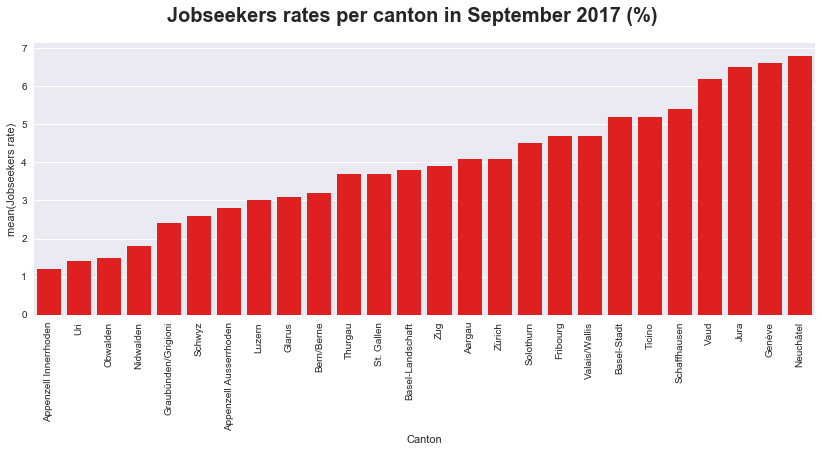

In [93]:
jobseekers_rates_data_sorted = jobseekers_rates_data.sort_values('Jobseekers rate')
ax = plt.figure(figsize = (14,5))
g = sns.barplot(x = 'Canton', y = 'Jobseekers rate', data = jobseekers_rates_data_sorted[['Canton','Jobseekers rate']], color ='Red')
g.set_xticklabels(labels = jobseekers_rates_data_sorted['Canton'], rotation=90)
ax.suptitle("Jobseekers rates per canton in September 2017 (%)", fontsize=20, fontweight="bold")

In [94]:
swiss_map_jobseekers_rates.save('jobseekers_rates_by_canton.html')

**7- Employed jobseekers rates analysis**<br>
For the last time we create a choropleth map to display Swiss cantons' employed jobseekers rates information
- We have chosen the coordinates of the middle of Switzerland to center our map. 
- Then, we initialize our map with these coordinates and make it a choropleth map with the topojson information converted to json in the previous steps after pre processing of the Cantons' names and we use the data on employed jobseekers rates to be displayed accordingly. We use a Yellow (low employed jobseekers rate) to Green (high employed jobseekers rate) sequential color which is by default divided into 6 equal intervals in the range of our employed jobseekers rates values by folium. 
- Finally, we create again strings for each canton to display info on the rates in pop ups windows.

In [95]:
swiss_map_employed_jobseekers_rates = folium.Map(middle_of_switzerland_coord, tiles='cartodbpositron', zoom_start = 8)
swiss_map_employed_jobseekers_rates.choropleth(geo_data=canton_geo_to_json,
              data=employed_jobseekers_rates_data, columns=['Canton', 'Employed jobseekers rate'],
                     key_on='feature.properties.name', fill_color='YlGn', fill_opacity=1, line_opacity=0.2,
             legend_name='Employed jobseeekers Rate (%)')

In [96]:
text3 = []
for i in range(employed_jobseekers_rates_data.index.size):
    text3.append(employed_jobseekers_rates_data.Canton[i] +  '<br>' + 
                'Employed jobseekers rate: ' + str(employed_jobseekers_rates_data['Employed jobseekers rate'].loc[i]) + '%')

In [97]:
list_geo=[]
gj=[]
for i in range(canton_geo_gdf.index.size):
     list_geo.append(mapping(canton_geo_gdf['geometry'].loc[i]))
     gj.append(folium.GeoJson(list_geo[i], style_function=lambda feature: {
        'opacity' : 0.7 , 'fillColor': '#FFFFFFFF', 'color' : 'blue'
        }))

In [98]:
for i in range(canton_geo_df.index.size):
    gj[i].add_child(folium.Popup(text3[i]))
    gj[i].add_to(swiss_map_employed_jobseekers_rates)

In [99]:
swiss_map_employed_jobseekers_rates.save('employed_jobseekers_rates_by_canton.html')

**See the results** : [Click here for resuts](https://hilefebvre.github.io/employed_jobseekers_rates_by_canton.html)

**8- Histogram of employed jobseekers rates by canton**<br>
Finally, before ending our analysis on employed jobseekers rates by canton we also display an histogram to have another view of these rates according to the different cantons. Values of employed jobseekers rates are again sorted in ascending order and displayed afterwards.

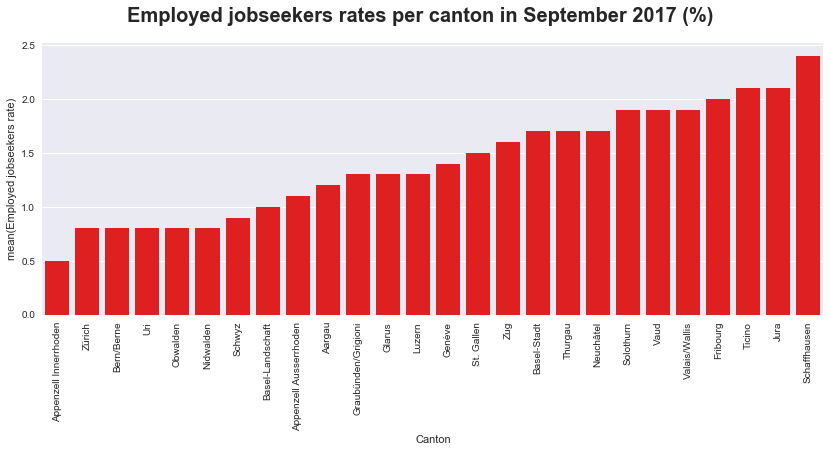

In [100]:
employed_jobseekers_rates_data_sorted = employed_jobseekers_rates_data.sort_values('Employed jobseekers rate')
ax = plt.figure(figsize = (14,5))
g = sns.barplot(x = 'Canton', y = 'Employed jobseekers rate', data = employed_jobseekers_rates_data_sorted[['Canton','Employed jobseekers rate']], color ='Red')
g.set_xticklabels(labels = employed_jobseekers_rates_data_sorted['Canton'], rotation=90)
ax.suptitle("Employed jobseekers rates per canton in September 2017 (%)", fontsize=20, fontweight="bold")

**Results interpretation:**<br> 
From the three generated maps and the histograms displayed, we can observe several interesting trends.
- First of all, the unemployement rates which represents only the unemployed people is close to the jobseekers rate. Indeed, the amount of employed jobseekers in this new rate does not affect the trends observed on the unemployement rate map. Genève, Neuchâtel, Jura and Vaud still are the cantons with the highest rates on both maps. While Appenzell Innerrhoden, Uri, Obwalden and Nidwalden remain the cantons with the lowest rates. The interesting fact to highlight here is that for the cantons with the highest rates, they all are bordering France. While three of the four cantons with the smallest rates are all in the middle of Switzerland. 
- On the other hand, we can observe that the map representing the employed jobseekers shows a little mix up on the trends. The cantons with highest and lowest rates mentionned above keep the same trend but for the other cantons we can see a little change in the values of their rate for this particular metric. But the most interesting trend to observe on this map is that the cantons with the lowest rates on the unemployement map tend to have a higher employed jobseekers rate than the actual unemployement rate. <br>

To assert our interpretations, we can compute a correlation matrix using the spearman method.

In [101]:
correlations = unemployement_numbers_data.corr(method = 'spearman')

In [102]:
correlations

,Unemployement rate,Unemployed,Jobseekers,Employed jobseekers,Active population,Jobseekers rate,Employed jobseekers rate
Unemployement rate,1.000000,0.724162,0.652636,0.597194,0.525668,0.962843,0.615047
Unemployed,0.724162,1.000000,0.982906,0.957607,0.943932,0.641464,0.299128
Jobseekers,0.652636,0.982906,1.000000,0.984957,0.975385,0.588779,0.311506
Employed jobseekers,0.597194,0.957607,0.984957,1.000000,0.978120,0.542251,0.329041
Active population,0.525668,0.943932,0.975385,0.978120,1.000000,0.448854,0.217298
Jobseekers rate,0.962843,0.641464,0.588779,0.542251,0.448854,1.000000,0.781190
Employed jobseekers rate,0.615047,0.299128,0.311506,0.329041,0.217298,0.781190,1.000000


From these numbers, we see that indeed the jobseekers rate is more correlated with the unemployement rate than to the employed jobseekers rate. Which explains the very little difference between the two maps. 
However, we see that the correlation between the unemployement rate and the employed jobseekers rate is about 0.6 which does not testify of a strong correlation between these two rates. It can justify of the little changes observed on the third map.

------

**Question 3:** 
Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

The Economic Secretary (SECO) releases a monthly report on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (hint The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

**1- Loading data on unemployement rates by canton in Switzerland**
The following loaded csv file was created through the amstat website https://www.amstat.ch/v2/index.jsp, Details section where we selected the 'Chômeurs et demandeurs d'emploi' folder and then 'Taux de chômage' folder. We are then asked to chose parameters before being given a data file with relative information on the selected parameters. Therefore, to produce this first csv file we chose the following parameters:

Here we choose to analyse unemployment rate for the wole 2016 year, and not only for one month. The idea here is to be able to analyse difference of rates between foreigners and swiss on a long term.

With these parameters, we are given a data file with information on the unemployement rates by canton and by nationality (Swiss or foreigner).

In [103]:
#Path of the excel file downloaded
unemployement_rates_file_nationalities = 'data/Chomage_Nationalities_per_Canton.xlsx'
#Reading of the file
unemployement_rates_data = pd.read_excel(unemployement_rates_file_nationalities,header=2)
#Keep the relevant columns
unemployement_rates_data=unemployement_rates_data.iloc[:,[1,2,4,5]]
#Rename headers
unemployement_rates_data=unemployement_rates_data.rename(columns={'Nationalité':'Nationality','durchschnittliche Anzahl Arbeitslose': 'Jobseekers', 'Taux de chômage (1 cav)': 'Unemployement rate'})

Let's have a look to the dataframe. We see that cantons are repeated twice, for each type of nationality ("Etrangers" and "Suisses"). This is not a problem for answering the first part of question.

In [104]:
unemployement_rates_data.head()

,Canton,Nationality,Jobseekers,Unemployement rate
0,Zurich,Etrangers,13703.000000,6.0
1,Zurich,Suisses,16380.916667,2.8
2,Berne,Etrangers,5791.833333,6.5
3,Berne,Suisses,9491.333333,2.0
4,Lucerne,Etrangers,1910.583333,4.7


As seen in the previous question, we need to map names of the cantons with the ones in the topojson that are in german. We need to copy twice the german name since cantons are doubled as seen previously. This has been seen in the previous question and we reeuse "canton_geo_df" for this matching.

In [105]:
iter=0
for german_name in canton_geo_df.name:
    unemployement_rates_data.Canton[iter]=german_name
    unemployement_rates_data.Canton[iter+1]=german_name
    iter=iter+2    

/Users/Hippo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Hippo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


We can check that our mapping has successfully worked:

In [106]:
unemployement_rates_data.head()

,Canton,Nationality,Jobseekers,Unemployement rate
0,Zürich,Etrangers,13703.000000,6.0
1,Zürich,Suisses,16380.916667,2.8
2,Bern/Berne,Etrangers,5791.833333,6.5
3,Bern/Berne,Suisses,9491.333333,2.0
4,Luzern,Etrangers,1910.583333,4.7


Let's convert number in numerical values, they are str for the moment.

In [107]:
unemployement_rates_data['Unemployement rate'] = pd.to_numeric(unemployement_rates_data['Unemployement rate'])
unemployement_rates_data['Jobseekers'] = pd.to_numeric(unemployement_rates_data['Jobseekers'])

**Creating pop up windows for interactive unemployement rates information on the map**
Indeed, we want the map to be as interactive as possible and make the information retrieved from the amstat website easy to reach and visible. To do so, we will make use of pop up windows which will relate information on the canton's name and its related unemployement rate.<br>
- First, we create a list of texts which contains the name and unemployement rate strings for each canton, for both nationalities.


In [108]:
text_Foreigners = []
text_Swiss = []

for i in range(0,unemployement_rates_data.index.size,2):
    text_Foreigners.append(unemployement_rates_data.Canton[i] +  '<br>' + 
                'Unemployement rate foreigners: ' + str(unemployement_rates_data['Unemployement rate'].loc[i]) + '%')
               
    text_Swiss.append(unemployement_rates_data.Canton[i] +  '<br>' +                   
                'Unemployement rate Swiss: ' + str(unemployement_rates_data['Unemployement rate'].loc[i+1]) + '%'
               )
    

- Secondly, we create the pop up objects delimited by the respective geometry of each canton.

In [109]:
list_geo_For=[]
gjf=[]
for i in range(canton_geo_gdf.index.size):#First popup for foreigners
     list_geo_For.append(mapping(canton_geo_gdf['geometry'].loc[i]))
     gjf.append(folium.GeoJson(list_geo[i], style_function=lambda feature: {
        'opacity' : 0.7 , 'fillColor': '#FFFFFFFF', 'color' : 'blue'
        }))
    
list_geo_Swi=[]
gjs=[]
for i in range(canton_geo_gdf.index.size):#Second popup for Swiss
     list_geo_Swi.append(mapping(canton_geo_gdf['geometry'].loc[i]))
     gjs.append(folium.GeoJson(list_geo[i], style_function=lambda feature: {
        'opacity' : 0.7 , 'fillColor': '#FFFFFFFF', 'color' : 'blue'
        }))

**Creating choropleth map to display Swiss cantons' unemployement rates information**<br>
- We have chosen the coordinates of the middle of Switzerland to center our map. 
- Then, we initialize our map with these coordinates and make it a choropleth map with the topojson information converted to json in the previous steps after pre processing of the Cantons' names and we use the data on unemployement rates to be displayed accordingly. We use a Yellow (low unemployement rate) to Green (high unemployement rate) sequential color which is by default divided into 6 equal intervals in the range of our unemployement rates values by folium. 
- Finally, we add the above created information strings into the pop up windows before displaying the choropleth map

We create the two maps and assign them data and properties:

In [110]:
swiss_map_unemployement_rates_Foreigners = folium.Map(middle_of_switzerland_coord, tiles='cartodbpositron', zoom_start = 8)
swiss_map_unemployement_rates_Swiss=folium.Map(middle_of_switzerland_coord, tiles='cartodbpositron', zoom_start = 8)

swiss_map_unemployement_rates_Foreigners.choropleth(geo_data=canton_geo_to_json,
              data=unemployement_rates_data.iloc[::2] , columns=['Canton', 'Unemployement rate'],
                     key_on='feature.properties.name', fill_color='YlGn', fill_opacity=1, line_opacity=0.2,
             legend_name='Unemployment Rate of Foreigners (%)')


swiss_map_unemployement_rates_Swiss.choropleth(geo_data=canton_geo_to_json,
              data=unemployement_rates_data.iloc[1::2] , columns=['Canton', 'Unemployement rate'],
                     key_on='feature.properties.name', fill_color='YlGn', fill_opacity=1, line_opacity=0.2,
             legend_name='Unemployment Rate of Swiss (%)')


In this case natural breaks are not really relevant since unemployement rate is pretty uniform on the range of values.

And add the popups:

In [111]:
for i in range(canton_geo_df.index.size):
    gjf[i].add_child(folium.Popup(text_Foreigners[i]))
    gjf[i].add_to(swiss_map_unemployement_rates_Foreigners)
    
    gjs[i].add_child(folium.Popup(text_Swiss[i]))
    gjs[i].add_to(swiss_map_unemployement_rates_Swiss)
    

Eventually, we save the two maps in html file. Maps are available by opening the html then.

In [112]:
swiss_map_unemployement_rates_Foreigners.save('swiss_map_unemployement_rates_Foreigners.html')
swiss_map_unemployement_rates_Swiss.save('swiss_map_unemployement_rates_Swiss.html')

Maps are avilable through the following hyperlink:
    [Map Foreigners](https://hilefebvre.github.io/swiss_map_unemployement_rates_Foreigners.html)
    [Map Swiss](https://hilefebvre.github.io/swiss_map_unemployement_rates_Swiss.html)

From this two map we notice that :
- Unemployment around french border is higher (in mean) than in the rest of the country. 
    This may be explained by fench people crossing boader every day to work in Switzerland.
- Unemployement tends to be lower in central switzerland and on the eastern cantons for both Swiss and Foreigners. We can assume that these cantons do not welcome as much as foreigners as Geneva or Zurich for instance. So it should make sense that foreigners living in these cantons must have come with a job in their pocket.

**To really analyse of unemployement for both categories, it could be interesting to compare differences of unemployement rates.**

Now we will create a map showing the difference between the two rates. We need to first get the data:

In [113]:
diff=[]#Difference between foreigners and Swiss

for i in range(0,unemployement_rates_data.index.size,2):
    diff.append(unemployement_rates_data.loc[i,"Unemployement rate"]-unemployement_rates_data.loc[i+1,"Unemployement rate"])

We merge difference rates with Cantons:

In [114]:
diff=np.array(diff)
df_diff = pd.DataFrame({'Canton':canton_geo_gdf.name, 'Unemployement difference':diff})

We create a new Swiss map:

In [115]:
swiss_map_unemployement_rates_diff=folium.Map(middle_of_switzerland_coord, tiles='cartodbpositron', zoom_start = 8)

And assign it the data:

In [116]:
swiss_map_unemployement_rates_diff.choropleth(geo_data=canton_geo_to_json,
              data=df_diff , columns=['Canton', 'Unemployement difference'],
                     key_on='feature.properties.name', fill_color='YlGn', fill_opacity=1, line_opacity=0.2,
             legend_name='Unemployment Rate - Difference between Foreigners and Swiss (%)')

We eventually save it in a html file:

In [117]:
swiss_map_unemployement_rates_diff.save('swiss_map_unemployement_rates_diff.html')

Results are uploaded here : [Map Difference](https://hilefebvre.github.io/swiss_map_unemployement_rates_diff.html)

This map provide us with interesting information:
- First, difference is always positive meaning that rate for foreigners is always higher than for Swiss. This means either there are too much foreigners for the number of jobs available or companies are not very willing to hire strangers.
- Difference may vary a lot between cantons from nearly null to more than 7%.
- Cosmopolite and international cantons such as Geneva or Zurich have low difference.

**Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.**

We downloaded from Amstat a new file gathering unemployement rates by cantons and age slice.

In [118]:
path='data/Chomage_par_age.xlsx'

In [119]:
df = pd.read_excel(path)
df.head()

,2.1 Taux de chômage,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Canton,"Classes d'âge 15-24, 25-49, 50 ans et plus",NaN,Mois,Septembre 2017,NaN,Total,NaN
2,NaN,NaN,NaN,Mesures,Taux de chômage,Chômeurs inscrits,Taux de chômage,Chômeurs inscrits
3,NaN,1,15-24 ans,NaN,3.7,3420,3.7,3420
4,Zurich,2,25-49 ans,NaN,3.4,17053,3.4,17053


The dataframe is messy, we need to clean it first :

In [120]:
df = df[3:len(df)-1]
#We rename colums
df = df.rename(columns={'2.1 Taux de chômage': 'Canton', 'Unnamed: 2': 'Age','Unnamed: 4': 'Rate' })
df = df[['Canton', 'Age', 'Rate']]
df = df.reset_index(drop=True)
df.head()

,Canton,Age,Rate
0,NaN,15-24 ans,3.7
1,Zurich,25-49 ans,3.4
2,NaN,50 ans et plus,2.9
3,NaN,15-24 ans,2.8
4,Berne,25-49 ans,2.5


Then, we just need to set proper canton names in the first column: We notice that canton's value are always on the same rown the middle age categrory

In [121]:
for i in range(len(df['Canton'])): 
    if(i%3 == 0):
        df['Canton'][i] = df['Canton'][i+1]
    elif(i%3 == 2):
        df['Canton'][i] = df['Canton'][i-1]

In [122]:
df.head()

,Canton,Age,Rate
0,Zurich,15-24 ans,3.7
1,Zurich,25-49 ans,3.4
2,Zurich,50 ans et plus,2.9
3,Berne,15-24 ans,2.8
4,Berne,25-49 ans,2.5


We transform Canton and Age into categorical variable and Rate into a numeric value (str until now)

In [123]:
df['Canton'] = df.Canton.astype('category')
df['Age'] = df.Age.astype('category')
df['Rate'] = pd.to_numeric(df['Rate'])

We eventually produce a barplot of age categories unemployment per canton:

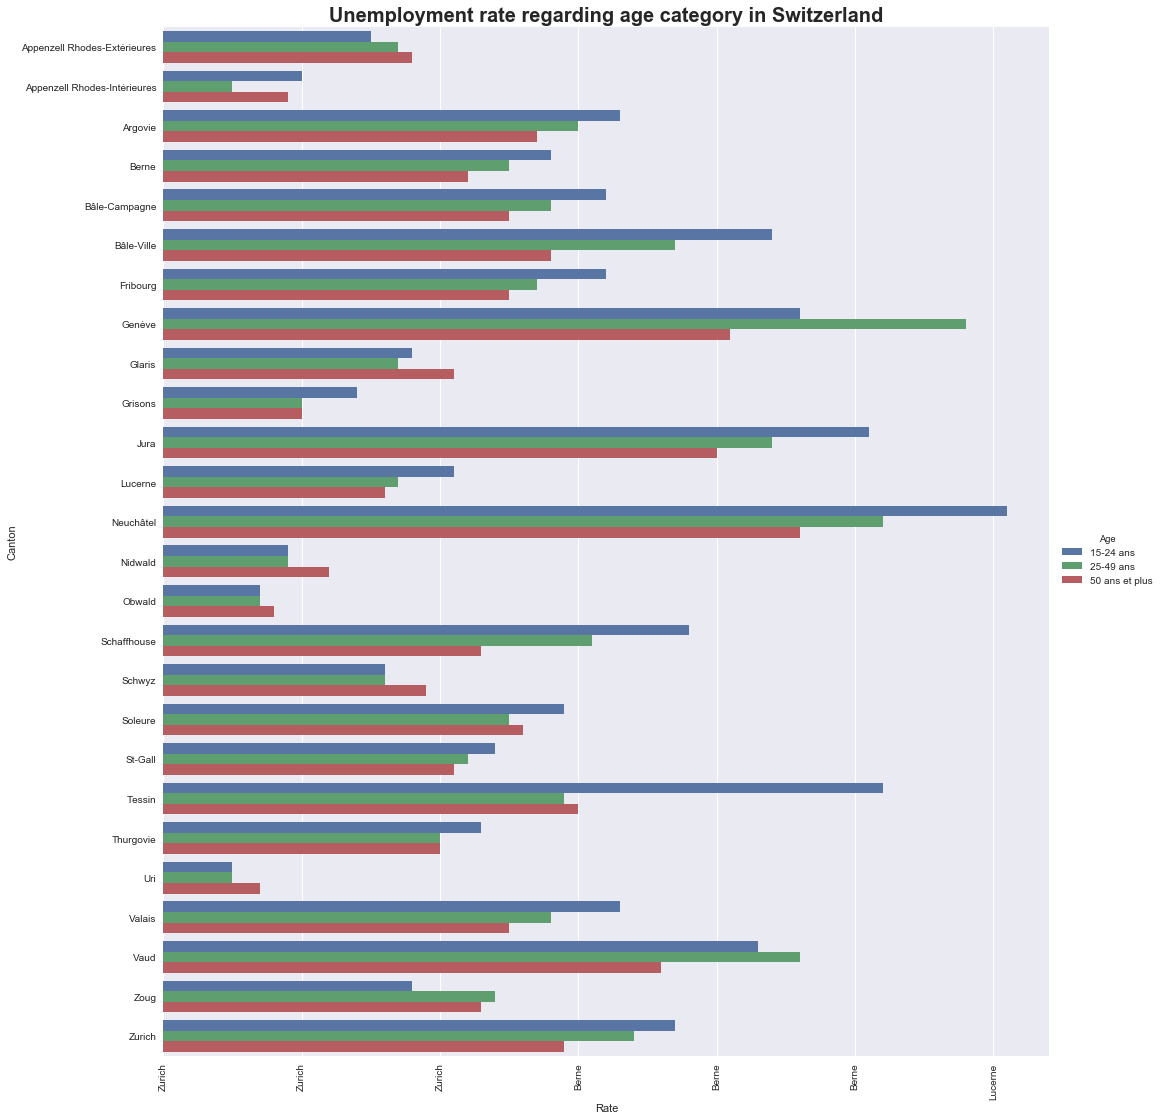

In [124]:
ax = plt.figure(figsize = (20,10));
g=sns.factorplot(x = 'Rate', y ='Canton', hue = 'Age', data = df, kind='bar', size=15,orient="h");
sns.plt.title("Unemployment rate regarding age category in Switzerland", fontsize=20, fontweight="bold")
g.set_xticklabels(labels = df['Canton'], rotation=90);

**From this barchart, we can see again than little central and estearn cantons have mostly the lowest eployment rates.
Moreover,unemployment repartition among age category is quite unfirom unless cantons sucg as Tessin or Neuchatel which have a huge 15-24 rate or Geneva with high middle category**

We can sump up this chart the following :
- Age repartition is mostly uniform
- When it's not, youngest category is most of the time the one which suffers the most from unemployment
- Geneve is an exception with a middle category very represented
- French speaking cantons such as Geneva, Vaud, Neuchatel and Jura as well Italian's one Tessin owns the highest peaks. This confirm that most of the economic production comes from the german's side dynamism. In addition, french cantons must suffer from french people coming to work in Switzerland probably dumping salaries.

### BONUS ### 

**Idea of solution**

We want to give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben. A first idea would be to assign each canton and dominant language ommiting the Romansh because it is few represented and quasi negligeable.

A solution would be to provide a new layer on unemployment rate per canton map (through **layercontrol()** props), allwoing us to display on the same map both rates and language repartition to see if unemployment rates may have a correlation with language and so cultures.